In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()

# bkg = read_h5_file(database_path, files["SM"])
# # SM processes

# neutral_boson = read_h5_file(database_path, files["neutral_boson"])
# print(neutral_boson.shape)
# # A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

# leptoquark = read_h5_file(database_path, files["leptoquark"])
# print(leptoquark.shape)
# # A leptoquark (LQ) with mass 80 GeV, decaying to a b quark and a τ lepton24

# neutral_Higgs = read_h5_file(database_path, files["neutral_Higgs"])
# print(neutral_Higgs.shape)
# # A scalar boson with mass 60 GeV, decaying to two tau leptons: h0→ ττ

# charged_Higgs = read_h5_file(database_path, files["charged_Higgs"])
# print(charged_Higgs.shape)
# # A charged scalar boson with mass 60 GeV, decaying to a tau lepton and a neutrino

events = {}
for key, value in files.items():
    events[key] = read_h5_file(database_path, value)
    print(key, events[key].shape)

SM (13451915, 19, 4)
neutral_boson (55969, 19, 4)
leptoquark (340544, 19, 4)
neutral_Higgs (691283, 19, 4)
charged_Higgs (760272, 19, 4)


In [4]:
signals = [key for key in events.keys() if key != "SM"]
print(signals)

['neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs']


# Load embedding model

In [5]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]
output_dim = model_hyper_parameters["output_dim"]

embedding_model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)
model_name = "emb_dim{}_type_scale{}.pt".format(output_dim, particle_type_scale) if EMD_config['pid_method'] == 'one-hot' else "emb_dim{}_sep.pt".format(output_dim)
embedding_model.load_state_dict(torch.load(os.path.join("..", "model", model_name)))
embedding_model.to(device)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ParticleEventTransformer(
  (particle_embedding): Linear(in_features=3, out_features=16, bias=True)
  (pos_encoder): ParticlePositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=304, out_features=4, bias=True)
)

# Embed events

In [6]:
from analysis import inference

In [7]:
from data import EventDataset

In [8]:
# infer_test_num = 1000000
# dataloaders = {}
# for key, value in events.items():
#     dataloaders[key] = DataLoader(EventDataset(value[:infer_test_num]), batch_size=256, num_workers=16, prefetch_factor=5)

dataloaders = {}
for key, value in events.items():
    dataloaders[key] = DataLoader(EventDataset(value), batch_size=256, num_workers=16, prefetch_factor=5)

In [9]:
embedding_points = {}

for key, value in dataloaders.items():
    embedding_points[key] = inference(embedding_model, value, embed_dim=output_dim)
    print(key, embedding_points[key].shape)

100%|██████████| 52547/52547 [01:47<00:00, 490.95it/s]


SM (13451915, 4)


100%|██████████| 219/219 [00:01<00:00, 117.05it/s]


neutral_boson (55969, 4)


100%|██████████| 1331/1331 [00:04<00:00, 319.63it/s]


leptoquark (340544, 4)


100%|██████████| 2701/2701 [00:06<00:00, 392.69it/s]


neutral_Higgs (691283, 4)


100%|██████████| 2970/2970 [00:07<00:00, 408.33it/s]

charged_Higgs (760272, 4)


In [10]:
from analysis import Normalizer

In [11]:
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [12]:
print(normalizer.max)
print(normalizer.min)

[369.1842041  370.31808472 327.48770142 326.72790527]
[-377.18408203 -356.34307861 -320.93734741 -340.06167603]


# Split embed points

In [13]:
from analysis import train_test_split, get_dataloaders

In [39]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"

selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)
exp_events = embedding_points['SM'][selected_idx[:n]]
bkg_events = embedding_points['SM'][selected_idx[n:]]
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=256)

# Classify Model

In [40]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [41]:
from metrics import BinaryACCUpdater

In [42]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [43]:
from classify import train_model

In [44]:
# opt_train_model  = torch.compile(train_model)

In [45]:
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

In [46]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-06-24 23:31:53
Epoch 1 / 50

100%|██████████| 13/13 [00:00<00:00, 57.11it/s, val_Accuracy=0.503, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5030230283737183 >>>>>>

================================================================================2024-06-24 23:31:56
Epoch 2 / 50

100%|██████████| 13/13 [00:00<00:00, 54.63it/s, val_Accuracy=0.504, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5038653612136841 >>>>>>

================================================================================2024-06-24 23:31:59
Epoch 3 / 50

100%|██████████| 13/13 [00:00<00:00, 54.56it/s, val_Accuracy=0.507, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5069384574890137 >>>>>>

================================================================================2024-06-24 23:32:01
Epoch 4 / 50

100%|██████████| 13/13 [00:00<00:00, 60.30it/s, val_Accuracy=0.507, val_loss=0.693]

==========================

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.693386,0.500650,0.693119,0.503023,1
1,0.693145,0.501450,0.693112,0.503865,2
2,0.693150,0.500412,0.693076,0.506938,3
3,0.693145,0.500473,0.693098,0.506873,4
4,0.693139,0.501042,0.693173,0.498981,5
5,0.693137,0.500281,0.693087,0.505331,6
6,0.693135,0.501304,0.693177,0.497112,7
7,0.693135,0.500835,0.693129,0.503577,8


# ROC

In [22]:
fpr_dict = {}
tpr_dict = {}
auc_dict = {}

In [23]:
from analysis import predict

In [24]:
targets, predictions = predict(naive_model, val_dataloader)

100%|██████████| 125/125 [00:00<00:00, 1095.80it/s]


0.49873028515625


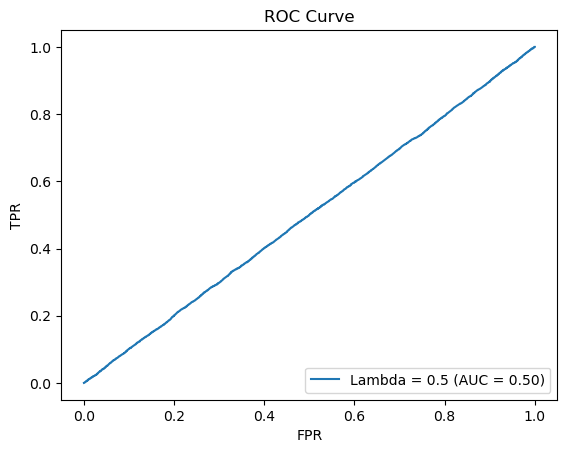

In [25]:
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Test statistics

In [47]:
from analysis import h_hat, Bootstrap_Permutation

In [29]:
%timeit selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)

358 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
hypothesis_dict = load_toml_config("hypothesis_test")
n = hypothesis_dict["n"]
n_null = hypothesis_dict["n_null"]

In [48]:
auc_results = np.zeros(n_null)
lrt_results = np.zeros(n_null)
mce_results = np.zeros(n_null)
for i in tqdm(range(n_null)):
    selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)
    exp_events = embedding_points['SM'][selected_idx[:n]]
    bkg_events = embedding_points['SM'][selected_idx[n:]]
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    n2 = len(W2)
    m2 = len(X2)
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}

    train_model(  
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50,
        verbose=False
        )
    bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
    auc_results[i] = bootstrap_permutation.auc_exp
    lrt_results[i] = bootstrap_permutation.lrt_exp
    mce_results[i] = bootstrap_permutation.mce_exp

  1%|          | 11/1000 [05:29<7:13:17, 26.29s/it]Exception ignored in: <function _releaseLock at 0x7f9c8b1e5260>
Traceback (most recent call last):
  File "/home/desmondhe/anaconda3/envs/ad/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
  1%|          | 12/1000 [05:48<6:35:00, 23.99s/it]

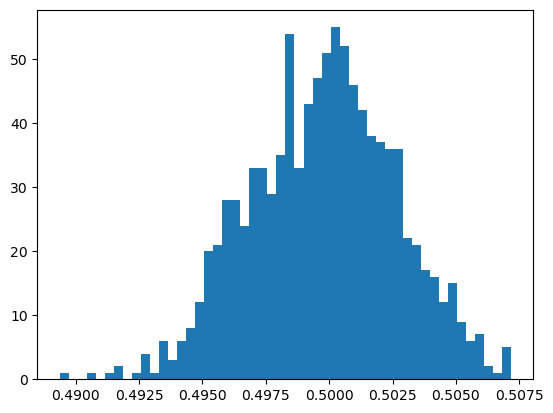

In [30]:
plt.hist(auc_results, bins=50)
plt.show()

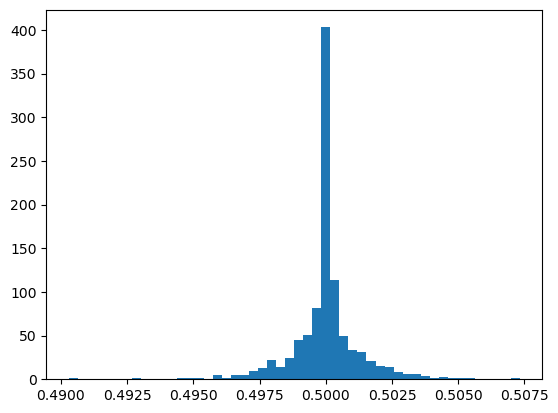

In [31]:
plt.hist(mce_results, bins=50)
plt.show()

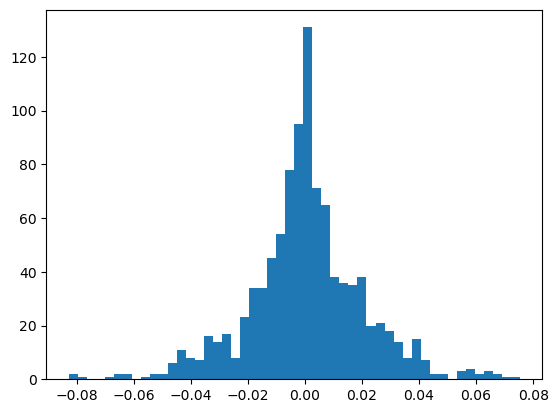

In [32]:
plt.hist(lrt_results, bins=50)
plt.show()

In [33]:
# Find threshold for 95% confidence level
lrt_threshold = np.percentile(lrt_results, 95)
print(lrt_threshold)

# Find threshold for 95% confidence level
mce_threshold = np.percentile(mce_results, 5)
print(mce_threshold)

# Find threshold for 95% confidence level
auc_threshold = np.percentile(auc_results, 95)
print(auc_threshold)

0.034097843445638314
0.49787375
0.5044355698749999


In [34]:
import toml
toml_file = '../config.toml'
with open(toml_file, 'r') as f:
    config = toml.load(f)
 
config['threshold']['lrt'] = float(lrt_threshold)
config['threshold']['mce'] = float(mce_threshold)
config['threshold']['auc'] = float(auc_threshold)
with open(toml_file, 'w') as f:
    toml.dump(config, f)